# PS7 Solutions

## Part 1

### Problem 1

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import sklearn.datasets
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.model_selection
import sklearn.metrics

import torch
import skorch

### Problem 2

In [2]:
bunch_elevators = sklearn.datasets.fetch_openml(
    data_id=216,
    as_frame=True,
    parser='auto'
)

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


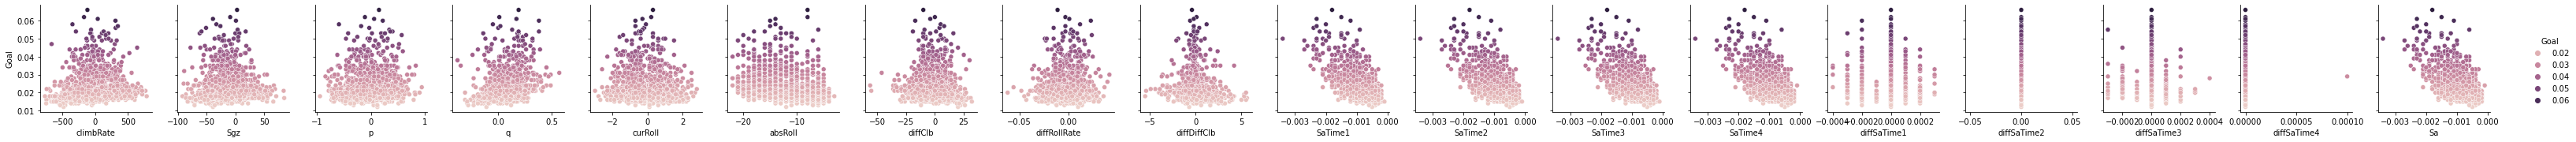

In [3]:
sns.pairplot(
    data=bunch_elevators.frame.sample(frac=0.1),
    y_vars="Goal",
    hue="Goal"
)

absRoll, diffSaTime1, diffSaTime2, diffSaTime3, diffSaTime4 all look like they aren't helpful.

data seems to be nonlinear.

<Axes: xlabel='Goal', ylabel='Count'>

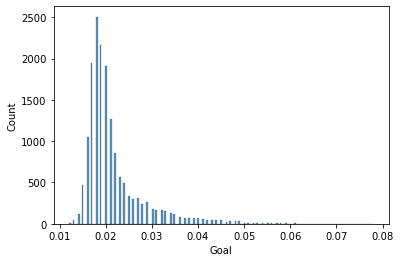

In [4]:
sns.histplot(data=bunch_elevators.target)

In [5]:
np.any(bunch_elevators.data.isna()) 

False

### Problem 3

In [7]:
import importlib
import ps6_funcs as ps6f
importlib.reload(ps6f)

<module 'ps6_funcs' from 'C:\\Users\\Agonz\\Downloads\\EE5830\\week10\\ps6_funcs.py'>

### Problem 4


In [8]:
df_elevators_clean_full = pd.concat([bunch_elevators.frame]).drop(  
    columns = ["absRoll", "diffSaTime1", "diffSaTime2", "diffSaTime3", "diffSaTime4"])
df_elevators_clean_full.describe()

,climbRate,Sgz,p,q,curRoll,diffClb,diffRollRate,diffDiffClb,SaTime1,SaTime2,SaTime3,SaTime4,Sa,Goal
count,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000
mean,-11.795771,-12.798783,-0.010076,0.054490,0.046894,-0.569793,-0.001049,-0.033978,-0.000750,-0.000754,-0.000754,-0.000757,-0.000757,0.021625
std,277.593632,25.439814,0.310457,0.115866,0.951701,10.568555,0.012587,0.949416,0.000402,0.000407,0.000408,0.000410,0.000410,0.006717
min,-993.000000,-99.000000,-1.370000,-0.450000,-3.000000,-56.000000,-0.084000,-8.300000,-0.003500,-0.003500,-0.003500,-0.003400,-0.003400,0.012000
25%,-200.000000,-29.000000,-0.230000,-0.030000,-0.600000,-8.000000,-0.009000,-0.200000,-0.000900,-0.000900,-0.000900,-0.001000,-0.001000,0.018000
50%,-31.000000,-13.000000,0.000000,0.050000,0.100000,0.000000,-0.001000,-0.100000,-0.000700,-0.000700,-0.000700,-0.000700,-0.000700,0.020000
75%,177.000000,3.000000,0.220000,0.130000,0.700000,6.000000,0.007000,0.100000,-0.000500,-0.000500,-0.000500,-0.000500,-0.000500,0.023000
max,973.000000,94.000000,1.090000,0.690000,2.900000,45.000000,0.056000,8.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000


In [9]:
elevators_X_train, elevators_X_test, elevators_y_train, elevators_y_test = sklearn.model_selection.train_test_split(
    df_elevators_clean_full.drop(columns=["Goal"]), 
    df_elevators_clean_full["Goal"], 
    test_size=0.3, 
    random_state=7
)

In [10]:
desired_features = 7


elevators_torch_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=desired_features
    )),
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("estimator", skorch.NeuralNetRegressor(
        ps6f.PS6RegressorModule,
        optimizer=torch.optim.Adam,
        lr=0.4,
        max_epochs=50,
        callbacks=[skorch.callbacks.EarlyStopping(
            patience=10)],
        batch_size=200,
    ))
]
elevators_torch_pipeline = sklearn.pipeline.Pipeline(elevators_torch_pipeline_steps)

In [11]:
elevators_torch_pipeline["estimator"].module__n_input_features = desired_features
elevators_torch_pipeline["estimator"].module__dense_layer_sizes = (30, 30,)

In [12]:
elevators_X_train.to_numpy().dtype

dtype('float64')

In [13]:
elevators_y_train.values.dtype

dtype('float64')

In [14]:
elevators_X_train.astype('float32').describe()

,climbRate,Sgz,p,q,curRoll,diffClb,diffRollRate,diffDiffClb,SaTime1,SaTime2,SaTime3,SaTime4,Sa
count,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000
mean,-9.361907,-12.496256,-0.010842,0.055484,0.043386,-0.637749,-0.001005,-0.035976,-0.000751,-0.000754,-0.000754,-0.000757,-0.000757
std,277.396454,25.360823,0.309835,0.116064,0.955845,10.588226,0.012637,0.954051,0.000403,0.000408,0.000408,0.000411,0.000411
min,-993.000000,-99.000000,-1.370000,-0.450000,-3.000000,-56.000000,-0.084000,-8.300000,-0.003400,-0.003400,-0.003400,-0.003400,-0.003400
25%,-199.000000,-28.000000,-0.240000,-0.030000,-0.600000,-8.000000,-0.009000,-0.200000,-0.000900,-0.000900,-0.000900,-0.001000,-0.001000
50%,-28.000000,-13.000000,0.000000,0.050000,0.100000,0.000000,-0.001000,-0.100000,-0.000700,-0.000700,-0.000700,-0.000700,-0.000700
75%,181.000000,3.000000,0.220000,0.130000,0.700000,6.000000,0.007000,0.100000,-0.000500,-0.000500,-0.000500,-0.000500,-0.000500
max,973.000000,93.000000,1.090000,0.690000,2.900000,45.000000,0.056000,8.500000,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100


### Problem 5, 6, 7


In [15]:
elevators_torch_pipeline.fit(elevators_X_train.to_numpy().astype('float32'), elevators_y_train.values.astype('float32').reshape(-1,1))

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      126.1890        0.2780  0.6729
      2        0.0420        0.0020  0.4787
      3        0.0004        0.0001  0.3134
      4        0.0000        0.0000  0.3147
      5        0.0000        0.0000  0.3072
      6        0.0000        0.0000  0.3024
      7        0.0000        0.0000  0.3003
      8        0.0000        0.0000  0.2910
      9        0.0000        0.0000  0.3910
     10        0.0000        0.0000  0.3963
     11        0.0000        0.0000  0.3180
     12        0.0000        0.0000  0.3270
     13        0.0000        0.0000  0.3043
     14        0.0000        0.0000  0.3085
Stopping since valid_loss has not improved in the last 10 epochs.


Pipeline(steps=[('selector',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_regression at 0x0000020584FC3C70>)),
                ('scaler', StandardScaler()),
                ('estimator',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=PS6RegressorModule(
    (dense_network): ModuleList(
      (0): Linear(in_features=7, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=30, bias=True)
    )
    (output): Linear(in_features=30, out_features=1, bias=True)
  ),
))])

In [16]:
elevators_torch_pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('selector',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_regression at 0x0000020584FC3C70>)),
                ('scaler', StandardScaler()),
                ('estimator',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=PS6RegressorModule(
    (dense_network): ModuleList(
      (0): Linear(in_features=7, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=30, bias=True)
    )
    (output): Linear(in_features=30, out_features=1, bias=True)
  ),
))])>

In [17]:
elevators_torch_pipeline.score(elevators_X_train.to_numpy().astype('float32'), elevators_y_train.values.astype('float32'))

-0.00034066916806674286

In [18]:
elevators_torch_pipeline.score(elevators_X_test.to_numpy().astype('float32'), elevators_y_test.values.astype('float32'))

-0.0003512714984179599

In [19]:
elevators_y_pred = elevators_torch_pipeline.predict(elevators_X_test.to_numpy().astype('float32'))

In [20]:
elevators_y_pred.shape

(4980, 1)

<Axes: ylabel='Goal'>

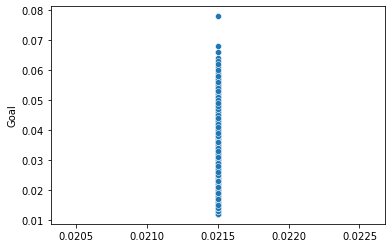

In [21]:
sns.scatterplot(y=elevators_y_test, x=elevators_y_pred[:,0])

In [22]:
sklearn.metrics.mean_absolute_error(y_true=elevators_y_test, y_pred=elevators_y_pred[:,0])

0.004559202209509999

In [23]:
elevators_torch_pipeline["estimator"].module_.dense_network[0].weight, elevators_torch_pipeline["estimator"].module_.dense_network[0].bias

(Parameter containing:
 tensor([[-1.5205,  2.8234, -1.4632, -1.9920, -1.4232, -1.4158, -1.7880],
         [-1.8747,  2.2675, -1.6044, -1.6994, -2.0566, -1.6900, -1.8129],
         [-2.0780,  1.8591, -1.7548, -1.7021, -1.9123, -2.1496, -1.9878],
         [ 1.4641, -1.6095,  1.9811,  1.7969,  1.8728,  1.4295,  1.6653],
         [-2.0332, -2.2904,  2.1359,  1.8974,  1.7764,  1.7694,  1.9590],
         [-1.9583, -1.8226,  1.7526,  1.9109,  1.6482,  1.5178,  1.9277],
         [-2.1726, -1.7784,  1.2993,  1.3632,  1.9668,  1.4583,  1.9886],
         [-1.6769,  1.8510, -1.7663, -1.9019, -1.9206, -2.0164, -1.4806],
         [-1.8388, -1.7266,  1.8269,  1.9146,  1.8617,  2.0458,  1.4154],
         [-1.6163,  1.5203, -1.8360, -1.4844, -1.6909, -1.8833, -1.6306],
         [-2.5068,  2.7931, -1.4516, -1.6426, -1.4719, -1.5643, -1.8556],
         [-2.3524,  1.7742, -2.1342, -1.7915, -1.7925, -1.9001, -1.6100],
         [ 0.2068, -1.5956,  1.6676,  1.3096,  1.2954,  1.5110,  1.6234],
         [-1.79

In [24]:
elevators_torch_pipeline["estimator"].module_.dense_network[1].weight, elevators_torch_pipeline["estimator"].module_.dense_network[1].bias

(Parameter containing:
 tensor([[-2.4325e+00, -2.4533e+00, -2.4896e+00, -2.3434e+00,  1.3521e-02,
          -2.3842e+00, -2.4326e+00, -2.2464e+00, -2.4697e+00, -2.4919e+00,
          -2.4625e+00, -2.4069e+00, -2.4568e+00, -2.2550e+00, -2.3440e+00,
          -2.2247e+00, -2.3406e+00, -2.5829e+00, -2.3707e+00, -2.2739e+00,
          -2.3468e+00, -2.2366e+00, -2.5293e+00, -2.3660e+00, -2.4978e+00,
          -2.3130e+00, -2.2666e+00, -2.2956e+00, -2.2826e+00, -2.3879e+00],
         [-2.4751e+00, -2.5458e+00, -2.4428e+00, -2.5560e+00, -1.0906e-01,
          -2.3780e+00, -2.5469e+00, -2.5829e+00, -2.5478e+00, -2.2804e+00,
           1.2714e-01, -2.2667e+00, -2.4528e+00,  1.4702e-01, -2.5524e+00,
          -2.4499e+00, -2.3472e+00, -2.5463e+00, -2.3001e+00, -2.5844e+00,
          -2.4891e+00, -2.3548e+00, -2.5579e+00, -2.5564e+00, -2.5437e+00,
          -2.4774e+00, -2.4466e+00, -2.2774e+00, -2.2853e+00, -2.5132e+00],
         [-1.5529e-01, -2.2460e+00, -2.2315e+00, -1.5833e-01, -2.7251e-02,


We see that the score of the training data and test data are very similar, likewise the MAE is very small which shows the the fitting accurately represents what our output should be.

## Part 2

In [25]:
import ps6_leakyfuncs as ps6lf
importlib.reload(ps6lf)

<module 'ps6_leakyfuncs' from 'C:\\Users\\Agonz\\Downloads\\EE5830\\week10\\ps6_leakyfuncs.py'>

In [26]:
desired_features = 6

elevators_net_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", skorch.NeuralNetRegressor(
        ps6lf.PS6RegressorModule,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.L1Loss,
        lr=0.4,
        max_epochs=50,
        callbacks=[skorch.callbacks.EarlyStopping(
            patience=10)],
        batch_size=200,
    ))
]

elevators_net_pipeline = sklearn.pipeline.Pipeline(elevators_net_pipeline_steps)

In [27]:
elevators_net_pipeline["estimator"].module__n_input_features = desired_features
elevators_net_pipeline["estimator"].module__dense_layer_sizes = (30, 30,)

In [28]:
param_grid = {
    "estimator__module__dense_layer_sizes": (
        (26, 26,),
        (30, 30,),
        (10, 10,),
        (26, 26, 26,),
        (30, 30, 30,),
        (10, 10, 10,),
    ),
}

In [29]:
elevators_net_cv = sklearn.model_selection.GridSearchCV(
    elevators_net_pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    #n_jobs=2,
    verbose=3,
    return_train_score=True
)

In [30]:
elevators_net_cv.fit(elevators_X_train.to_numpy().astype('float32'), elevators_y_train.values.astype('float32').reshape(-1,1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5983        0.1160  0.5750
      2        0.3733        0.3708  0.4168
      3        0.0973        0.0514  0.3560
      4        0.0506        0.0557  0.3148
      5        0.0302        0.0288  0.2894
      6        0.0236        0.0296  0.2648
      7        0.0344        0.0109  0.2851
      8        0.0404        0.0216  0.2814
      9        0.0238        0.0115  0.2796
     10        0.0253        0.0349  0.2839
     11        0.0304        0.0183  0.2700
     12        0.0361        0.0126  0.2545
     13        0.0540        0.0839  0.2804
     14        0.0496        0.0300  0.3027
     15        0.0474        0.0374  0.2694
     16        0.0467        0.0677  0.2946
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-0.029, test=-0.029) total time=   7.5s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.3185        0.6091  0.5892
      2        0.1884        0.0753  0.4493
      3        0.1560        0.0952  0.3821
      4        0.1465        0.2430  0.3027
      5        0.1354        0.0639  0.2255
      6        0.0706        0.0616  0.3093
      7        0.0459        0.0744  0.2427
      8        0.0605        0.0893  0.3197
      9        0.0498        0.0195  0.2938
     10        0.0221        0.0589  0.3053
     11        0.0446        0.0431  0.2873
     12        0.0534        0.1598  0.2213
     13        0.0345        0.0126  0.3628
     14        0.0266        0.0278  0.3972
     15        0.0271        0.0241  0.3749
     16        0.0266        0.0429  0.3120
     17        0.0269        0.0203  0.3236
     18        0.0260        0.0409  0.2686
     19        0.0263        0.0174  0.2478
     20        0.0254        0.0394  0.2431
     21        0.0258        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5744        0.4109  0.5259
      2        0.0877        0.0344  0.4147
      3        0.0387        0.0100  0.3792
      4        0.0296        0.0125  0.2499
      5        0.0793        0.1036  0.2544
      6        0.0425        0.0572  0.2244
      7        0.0559        0.0112  0.2424
      8        0.0438        0.0425  0.2353
      9        0.0391        0.0100  0.2475
     10        0.0372        0.0453  0.2441
     11        0.0308        0.0073  0.2485
     12        0.0316        0.0503  0.2302
     13        0.0277        0.0473  0.2501
     14        0.0292        0.0289  0.2627
     15        0.0285        0.0495  0.2360
     16        0.0328        0.0326  0.2566
     17        0.0285        0.0109  0.2834
     18        0.0267        0.0314  0.3746
     19        0.0269        0.0085  0.2409
     20        0.0247        0.0213  0.2509
Stopping since valid_loss has no

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.5699        0.3584  0.5748
      2        0.2214        0.0781  0.4434
      3        0.0589        0.0479  0.3477
      4        0.0540        0.0303  0.2983
      5        0.0506        0.0768  0.2569
      6        0.0513        0.0342  0.2415
      7        0.0494        0.0250  0.2283
      8        0.0488        0.0798  0.2483
      9        0.0485        0.0314  0.2409
     10        0.0462        0.0184  0.2420
     11        0.0448        0.0567  0.2384
     12        0.0808        0.1624  0.2422
     13        0.1466        0.0174  0.2345
     14        0.1092        0.1728  0.2244
     15        0.0774        0.0233  0.2344
     16       14.8316        3.6556  0.2470
     17        1.8576        0.9317  0.2298
     18        1.1784        0.4844  0.2342
     19        0.4739        0.6156  0.2482
     20        0.2391        0.4661  0.2322
     21        0.3708        0.1

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.1816        0.3001  0.5041
      2        0.1116        0.0898  0.3785
      3        0.1079        0.0580  0.3663
      4        0.0387        0.0219  0.2323
      5        0.0628        0.0120  0.2264
      6        0.0282        0.0246  0.2388
      7        0.0320        0.0435  0.2406
      8        0.0315        0.0346  0.2372
      9        0.0303        0.0386  0.2845
     10        0.0294        0.0456  0.2406
     11        0.0302        0.0384  0.2202
     12        0.0267        0.0345  0.2221
     13        0.0373        0.0184  0.2422
     14        0.0587        0.0750  0.2335
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-0.039, test=-0.039) total time=   5.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.7418        0.7930  0.4961
      2        0.2829        0.0750  0.4266
      3        0.0761        0.0452  0.2721
      4        0.0478        0.0163  0.2502
      5        0.0458        0.0185  0.2433
      6        0.0341        0.0181  0.2367
      7        0.0322        0.0085  0.2362
      8        0.0612        0.0310  0.2601
      9        0.0403        0.0292  0.2433
     10        0.0921        0.1905  0.2424
     11        0.1212        0.1159  0.2361
     12        0.0622        0.0348  0.2504
     13        0.0245        0.0307  0.2509
     14        0.0265        0.0441  0.2364
     15        0.0411        0.0330  0.2451
     16        0.0480        0.0135  0.2348
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.060, test=-0.060) total time=   6.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.6393        0.4686  0.5241
      2        0.0970        0.0422  0.4165
      3        0.0374        0.0726  0.3184
      4        0.0768        0.0425  0.2521
      5        0.0619        0.0473  0.2479
      6        0.0394        0.1305  0.2383
      7        0.0608        0.0485  0.2364
      8        0.0597        0.0848  0.2365
      9        0.0399        0.0122  0.2450
     10        0.0350        0.0074  0.2394
     11        0.0482        0.0364  0.2481
     12        0.0559        0.0981  0.2343
     13        0.2830        0.7479  0.2366
     14        0.4526        0.4660  0.2428
     15        2.8437        8.4453  0.2441
     16        5.7140        0.5891  0.2407
     17        0.4811        0.5590  0.2377
     18        0.2298        0.1263  0.2323
     19        0.1093        0.1770  0.2366
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9096        0.2364  0.4961
      2        0.1806        0.1414  0.4234
      3        0.0525        0.0243  0.3534
      4        0.0339        0.0389  0.2564
      5        0.0333        0.0436  0.2463
      6        0.0314        0.0392  0.2402
      7        0.0305        0.0258  0.2262
      8        0.0292        0.0424  0.2525
      9        0.0292        0.0348  0.2342
     10        0.0281        0.0417  0.2323
     11        0.0352        0.0340  0.2268
     12        0.1637        0.4032  0.2502
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-11.034, test=-10.446) total time=   5.2s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.8699        2.7733  0.4921
      2        0.7544        0.3652  0.3700
      3        0.4276        0.1086  0.2519
      4        0.1231        0.0286  0.2422
      5        0.2408        0.2048  0.2501
      6        0.0821        0.0436  0.2422
      7        0.0773        0.0956  0.2404
      8        0.0934        0.0132  0.2420
      9        0.0282        0.0164  0.2505
     10        0.0331        0.0458  0.2341
     11        0.0437        0.0502  0.2486
     12        0.0418        0.0409  0.2283
     13        0.0529        0.0538  0.2607
     14        0.0507        0.0415  0.2283
     15        0.0486        0.0385  0.2321
     16        0.0311        0.0331  0.2262
     17        0.0260        0.0234  0.2346
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.033, test=-0.033) tot

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.0953        0.6725  0.5462
      2        0.1752        0.0227  0.3796
      3        0.0249        0.0419  0.3071
      4        0.0445        0.0617  0.3661
      5        0.0422        0.0154  0.2672
      6        0.0250        0.0561  0.2837
      7        0.0364        0.0335  0.2576
      8        0.0436        0.0198  0.2588
      9        0.0414        0.0362  0.2812
     10        0.0312        0.0411  0.2584
     11        0.0320        0.0690  0.2573
     12        0.0860        0.0640  0.2525
     13        0.0544        0.0517  0.2470
     14        0.0471        0.0251  0.2441
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.091, test=-0.087) total time=   6.4s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2249        0.0642  0.5758
      2        0.0486        0.0083  0.5147
      3        0.0495        0.0094  0.3816
      4        0.0230        0.0908  0.2934
      5        0.0346        0.0371  0.3868
      6        0.0241        0.0098  0.5707
      7        0.0234        0.0307  0.3387
      8        0.0232        0.0079  0.3550
      9        0.0238        0.0324  0.2411
     10        0.0250        0.0148  0.3707
     11        0.0231        0.0277  0.4251
     12        0.0222        0.0296  0.3647
     13        0.0216        0.0279  0.2343
     14        0.0235        0.0091  0.2414
     15        0.0224        0.0335  0.2678
     16        0.0223        0.0088  0.2515
     17        0.0220        0.0312  0.2450
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-0.010, test=-0.010) tot

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7069        0.1455  0.5361
      2        0.0454        0.0250  0.4593
      3        0.0238        0.0206  0.4077
      4        0.0456        0.0642  0.3567
      5        0.0380        0.0046  0.3639
      6        0.0363        0.0561  0.4105
      7        0.0593        0.0398  0.2645
      8        0.0340        0.0324  0.2408
      9        0.0256        0.0121  0.2499
     10        0.0250        0.0371  0.2389
     11        0.0252        0.0100  0.2404
     12        0.0246        0.0357  0.2244
     13        0.0249        0.0093  0.2343
     14        0.0243        0.0392  0.2221
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-0.011, test=-0.011) total time=   6.4s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5163        0.0200  0.5211
      2        0.0290        0.0125  0.3951
      3        0.0270        0.0357  0.2507
      4        0.0262        0.0767  0.2442
      5        0.0498        0.0204  0.2321
      6        0.0449        0.0475  0.2325
      7        0.0455        0.0439  0.2347
      8        0.0447        0.0452  0.2319
      9        0.0437        0.0580  0.2293
     10        0.0441        0.0467  0.2262
     11        0.0437        0.0344  0.2262
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-0.048, test=-0.048) total time=   4.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5527        0.2279  0.5242
      2        0.1281        0.0932  0.3892
      3        0.0475        0.0221  0.2949
      4        0.0309        0.0140  0.2323
      5        0.0201        0.0085  0.2281
      6        0.0277        0.0400  0.2353
      7        0.0234        0.0288  0.2502
      8        0.0320        0.0834  0.2392
      9        0.0555        0.0565  0.2317
     10        0.0265        0.0059  0.2282
     11        0.0782        0.0751  0.2261
     12        0.0650        0.0815  0.2441
     13        0.0760        0.1111  0.2594
     14        0.0752        0.0670  0.2888
     15        0.0741        0.0787  0.3314
     16        0.0738        0.0484  0.2362
     17        0.0711        0.1035  0.2680
     18        0.0716        0.0665  0.2519
     19        0.0713        0.0782  0.2314
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2929        0.1069  0.4921
      2        0.0488        0.0393  0.4141
      3        0.0257        0.0497  0.2863
      4        0.0282        0.0314  0.2628
      5        0.0269        0.0125  0.3497
      6        0.0254        0.0112  0.3304
      7        0.0344        0.0923  0.2251
      8        0.0471        0.0481  0.2331
      9        0.0451        0.0171  0.2595
     10        0.0429        0.0799  0.2447
     11        0.0442        0.0264  0.2362
     12        0.0425        0.0097  0.2529
     13        0.0485        0.1059  0.2190
     14        0.0411        0.0832  0.2372
     15        0.0398        0.0187  0.2465
     16        0.0427        0.0050  0.2409
     17        0.0279        0.0690  0.2427
     18        0.0445        0.0379  0.2476
     19        0.0260        0.0103  0.2529
     20        0.0285        0.0131  0.2356
     21        0.0617        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       12.2223        7.4790  0.5724
      2        4.1689        0.6466  0.4542
      3        0.2475        0.5001  0.3128
      4        0.1954        0.2014  0.2476
      5        0.0860        0.1699  0.2695
      6        0.1426        0.0445  0.2505
      7        0.0587        0.0515  0.2905
      8        2.4806        0.5093  0.3306
      9        1.0443        0.3866  0.3284
     10        0.1983        0.1274  0.2656
     11        0.1049        0.1480  0.2544
     12        0.0809        0.0452  0.2830
     13        0.0584        0.0698  0.2699
     14        0.1682        0.1703  0.2463
     15        0.0956        0.1019  0.2615
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-0.046, test=-0.066) total time=   6.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.0286        0.4757  0.5732
      2        0.1080        0.1215  0.4336
      3        0.1227        0.1283  0.2579
      4        0.1235        0.0267  0.2751
      5        0.0590        0.1058  0.2553
      6        0.0399        0.0104  0.2755
      7        0.0570        0.0887  0.3441
      8        0.0685        0.1271  0.2956
      9        0.0509        0.0128  0.2713
     10        0.0298        0.0112  0.2756
     11        0.0473        0.0614  0.2719
     12        0.0528        0.0842  0.2704
     13        0.0547        0.0183  0.2658
     14        0.0673        0.0829  0.2578
     15        0.0870        0.0625  0.2790
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-0.082, test=-0.078) total time=   6.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.4988        9.4810  0.5513
      2        2.0722        0.1494  0.4233
      3        0.0825        0.0690  0.3045
      4        0.1753        1.4977  0.2877
      5        0.5622        0.2011  0.3195
      6        0.1137        0.0523  0.3222
      7        0.1174        0.3569  0.2716
      8        0.3426        0.3889  0.2825
      9        0.1145        0.1242  0.2805
     10        0.0837        0.1480  0.2802
     11        0.1024        0.1363  0.2837
     12        0.0725        0.0140  0.2988
     13        0.0592        0.0348  0.2634
     14        0.0965        0.0294  0.2654
     15        0.0410        0.0182  0.2646
     16        0.0780        0.0219  0.2637
     17        0.1183        0.2836  0.2510
     18        0.1120        0.0605  0.2562
     19        0.0988        0.2247  0.2485
     20        0.0846        0.0676  0.2442
     21        0.0364        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.4820        0.5764  0.4241
      2        1.8593        0.2417  0.3982
      3        0.2885        0.2379  0.2830
      4        0.1588        0.0528  0.2706
      5        0.0544        0.0563  0.2691
      6        0.0460        0.0141  0.2680
      7        0.0645        0.0853  0.2497
      8        0.0398        0.0420  0.2645
      9        0.0547        0.0099  0.2523
     10        0.0370        0.0074  0.2525
     11        0.0393        0.0438  0.2673
     12        0.0273        0.0182  0.2731
     13        0.0438        0.0211  0.2661
     14        0.0486        0.0192  0.2580
     15        0.0300        0.0242  0.2501
     16        0.0759        0.1005  0.2683
     17        0.0677        0.0610  0.2628
     18        0.0488        0.0377  0.2683
     19        0.0352        0.0333  0.2683
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.1324        0.1956  0.6159
      2        0.0757        0.1856  0.4215
      3        0.1029        0.1592  0.4780
      4        0.1000        0.2171  0.2585
      5        0.0959        0.1786  0.3404
      6        0.0911        0.0801  0.2964
      7        0.0736        0.0748  0.2543
      8        0.0291        0.0266  0.2708
      9        0.0682        0.0526  0.2642
     10        0.0499        0.0662  0.2662
     11        0.0718        0.0821  0.2602
     12        0.0705        0.0283  0.2565
     13        0.0926        0.0960  0.2603
     14      305.6173      451.4743  0.2623
     15       93.0808       11.7652  0.2705
     16       27.4331       48.2404  0.2718
     17       27.9798        8.7607  0.2543
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-17.321, test=-17.09

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9356        0.1134  0.5041
      2        0.1207        0.0432  0.4285
      3        0.0764        0.1033  0.3632
      4        0.1384        0.0428  0.2609
      5        0.1281        0.0929  0.2662
      6        0.1890        0.2203  0.2703
      7       49.5552       15.3567  0.2522
      8       51.2713       11.2893  0.2529
      9       76.8227       91.0461  0.2686
     10       98.1062        8.4887  0.2602
     11        8.3709        2.5046  0.2504
     12        3.2773        3.6417  0.2544
     13        2.4896        2.6705  0.2576
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-6.908, test=-7.066) total time=   5.5s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       14.5025        5.2640  0.6214
      2        3.4584        1.2520  0.4382
      3        0.4367        0.3586  0.3046
      4        1.0619        1.0123  0.2585
      5       28.6819       21.2044  0.2557
      6       13.5592       28.7492  0.2644
      7        6.2326        1.7076  0.2585
      8        1.1452        0.1787  0.2646
      9        0.3754        0.2896  0.2592
     10        0.4464        0.2916  0.2581
     11        0.4579        0.2020  0.2483
     12        0.2198        0.3739  0.2604
     13        0.1586        0.1603  0.2583
     14        0.2818        0.3552  0.2622
     15        0.1825        0.0453  0.2505
     16        0.3092        0.0465  0.2541
     17        0.1625        0.2996  0.2569
     18        0.2782        0.3737  0.2722
     19        1.5730        1.7556  0.2621
     20        0.8624        0.1075  0.2509
     21        0.6318        0.1

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.8624        1.3043  0.5761
      2        0.9885        0.6405  0.4526
      3        0.6358        0.1466  0.3693
      4       10.2953       19.6008  0.3390
      5        9.6605        2.2360  0.2589
      6        1.9277        4.6205  0.2639
      7        1.4747        2.2450  0.2583
      8        1.3803        3.4766  0.2582
      9        0.7110        0.1924  0.2682
     10        0.2947        0.4304  0.2676
     11        0.1771        0.1902  0.2521
     12        0.0870        0.0465  0.2547
     13        0.0725        0.1325  0.2698
     14        0.0610        0.0516  0.2863
     15        0.0803        0.1277  0.2686
     16        0.0743        0.0784  0.2522
     17        0.0420        0.0363  0.2485
     18        0.0483        0.0864  0.2521
     19        0.0754        0.0796  0.2589
     20        0.0807        0.0555  0.2676
     21        0.1310        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.8829        2.6852  0.5481
      2        6.9455       22.9019  0.4652
      3       15.6481        4.4104  0.2971
      4        1.7723        0.3027  0.2422
      5        0.3490        0.1851  0.2758
      6        1.2856        1.4869  0.2624
      7        0.8827        0.2850  0.2644
      8        0.8984        1.1138  0.2553
      9        3.4871        9.6710  0.2644
     10        4.1736        1.9526  0.2623
     11        0.8289        0.2792  0.2564
     12        0.3037        0.1330  0.2670
     13        0.5621        0.2462  0.2705
     14        0.2820        0.1844  0.2590
     15        0.1302        0.1116  0.2524
     16        0.1200        0.0339  0.2559
     17        0.1111        0.3573  0.2463
     18        0.1096        0.2351  0.2526
     19        0.1373        0.1137  0.2763
     20        0.0951        0.0602  0.2605
     21        0.0588        0.1

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        7.4831        0.6525  0.5121
      2        0.7396        0.0807  0.4497
      3        0.0842        0.0339  0.4056
      4        0.1322        0.1854  0.3105
      5        0.1255        0.0337  0.2674
      6        0.0519        0.0348  0.2721
      7        0.0518        0.0423  0.2525
      8        0.0316        0.0328  0.2602
      9        0.0315        0.0448  0.2811
     10        0.0360        0.0478  0.2706
     11        0.0338        0.0258  0.2704
     12        0.0393        0.0113  0.2646
     13        0.0458        0.0907  0.2544
     14        0.0706        0.0826  0.2463
     15        0.0647        0.0679  0.2543
     16        0.0533        0.0526  0.2401
     17       11.8927       51.4817  0.2647
     18      341.4622      790.3467  0.2702
     19      139.6690      154.7604  0.2788
     20       69.2155       28.1124  0.2842
     21       17.8994        7.4

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6253        0.1076  0.4561
      2        0.0386        0.0296  0.2583
      3        0.0267        0.0088  0.2528
      4        0.0452        0.0225  0.2502
      5        0.0264        0.0226  0.2505
      6        0.0588        0.0556  0.2401
      7        0.0766        0.1052  0.2504
      8        0.0754        0.0511  0.2508
      9        0.0723        0.0820  0.2507
     10        0.0717        0.0663  0.2466
     11        0.0704        0.0800  0.2523
     12        0.0698        0.0552  0.2383
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-0.089, test=-0.089) total time=   5.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5197        0.0588  0.5441
      2        0.0831        0.0318  0.3903
      3        0.0579        0.0138  0.2545
      4        0.0953        0.3878  0.2544
      5        0.0945        0.1106  0.2551
      6        0.0542        0.0365  0.2529
      7        0.0506        0.0488  0.2382
      8        1.2514        0.4758  0.2321
      9        1.1654        0.9588  0.2385
     10        1.0803        0.9719  0.2444
     11        0.7573        0.3840  0.2483
     12        0.3236        0.2010  0.2561
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-0.199, test=-0.200) total time=   5.2s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6489        0.1293  0.5081
      2        0.0767        0.0312  0.4102
      3        0.0392        0.0078  0.2484
      4        0.0713        0.0342  0.2462
      5        0.0352        0.0277  0.2343
      6        0.0282        0.0268  0.2543
      7        0.0415        0.0123  0.2439
      8        0.0793        0.0508  0.2384
      9        0.0439        0.0166  0.3033
     10        0.0422        0.0393  0.2623
     11        0.0272        0.0182  0.3026
     12        0.0261        0.0407  0.3281
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-0.015, test=-0.016) total time=   5.5s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4478        0.0443  0.6149
      2        0.0355        0.0328  0.3548
      3        0.0280        0.0391  0.3140
      4        0.0339        0.0476  0.3248
      5        0.0376        0.0471  0.2523
      6        0.0304        0.0219  0.2463
      7        0.0278        0.0354  0.2456
      8        0.0270        0.0243  0.2483
      9        0.0258        0.0422  0.2500
     10        0.0254        0.0754  0.2322
     11        0.0479        0.0361  0.2420
     12        0.0454        0.0312  0.2414
     13        0.0474        0.0296  0.2418
     14        0.0225        0.0676  0.2612
     15        0.0295        0.0071  0.3365
     16        0.0450        0.0284  0.2422
     17        0.0321        0.1034  0.2442
     18        0.0359        0.0168  0.2322
     19        0.0233        0.0192  0.2544
     20        0.0231        0.0267  0.2403
     21        0.0227        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0061        0.0593  0.4681
      2        0.0293        0.0193  0.3682
      3        0.0554        0.0728  0.2524
      4        0.0480        0.0329  0.2282
      5        0.0246        0.0076  0.2569
      6        0.0334        0.0467  0.2424
      7        0.0259        0.0428  0.2444
      8        0.0370        0.0524  0.2386
      9        0.0266        0.0133  0.2464
     10        0.0248        0.0375  0.2545
     11        0.0252        0.0142  0.2563
     12        0.0242        0.0363  0.2560
     13        0.0247        0.0185  0.2361
     14        0.0238        0.0379  0.2370
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-0.016, test=-0.016) total time=   5.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2587        0.0467  0.6962
      2        0.0956        0.0638  0.4502
      3        0.0610        0.0210  0.3366
      4        0.0254        0.0076  0.2767
      5        0.0397        0.0464  0.2796
      6        0.0465        0.0353  0.3031
      7        0.0450        0.0529  0.2824
      8        0.0446        0.0283  0.2787
      9        0.0432        0.0418  0.2863
     10        0.0422        0.0712  0.2723
     11        0.0424        0.0556  0.2884
     12        0.0426        0.0125  0.2843
     13        0.0419        0.0375  0.2866
Stopping since valid_loss has not improved in the last 10 epochs.


GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x0000020584FC3C70>)),
                                       ('scaler', RobustScaler()),
                                       ('estimator',
                                        <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'ps6_leakyfuncs.PS6RegressorModule'>,
  module__dense_layer_sizes=(30, 30),
  module__n_input_features=6,
))]),
             param_grid={'estimator__module__dense_layer_sizes': ((26, 26),
                                                                  (30, 30),
                                                                  (10, 10),
                                                                  (26, 26, 26),
                                                                  (30, 30, 30),
                                                                  (10, 10,
                                                                   10))},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=3)

In [31]:
elevators_net_cv.best_params_

{'estimator__module__dense_layer_sizes': (10, 10)}

In [32]:
pd.DataFrame(elevators_net_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__module__dense_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.022971,1.821657,0.049790,0.002612,"(26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-0.028820,-0.077370,-0.032374,-0.257134,-0.038921,-0.086924,0.086855,2,-0.028763,-0.078166,-0.032588,-0.254046,-0.039209,-0.086554,0.085578
1,6.224435,0.587559,0.047519,0.004986,"(30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-0.059542,-0.086290,-10.446321,-0.032777,-0.087155,-2.142417,4.152000,3,-0.059596,-0.086347,-11.034005,-0.032945,-0.090643,-2.260707,4.386698
2,7.193273,1.410495,0.046257,0.003187,"(10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-0.009842,-0.010532,-0.048065,-0.045912,-0.017740,-0.026418,0.017035,1,-0.009868,-0.010673,-0.047959,-0.045881,-0.017815,-0.026439,0.016963
3,7.472580,0.632362,0.050936,0.007948,"(26, 26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-0.066116,-0.078262,-0.019954,-0.057068,-17.092079,-3.462696,6.814720,4,-0.046309,-0.081858,-0.020248,-0.056787,-17.320505,-3.505142,6.907710
4,8.093198,1.336420,0.048909,0.003853,"(30, 30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-7.065523,-13.383062,-0.049889,-0.076349,-5.596938,-5.234352,4.967289,5,-6.908026,-13.263240,-0.049514,-0.076831,-5.836774,-5.226877,4.921573
5,6.187536,1.484406,0.054150,0.013831,"(10, 10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-0.089078,-0.200019,-0.015644,-160.789459,-0.016146,-32.222069,64.283730,6,-0.089165,-0.199398,-0.015491,-159.976837,-0.016232,-32.059425,63.958742


In [33]:
elevators_net_cv.best_score_

-0.026418402232229708

In [35]:
desired_features = 6

elevators_net_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("estimator", skorch.NeuralNetRegressor(
        ps6f.PS6RegressorModule,
        optimizer=torch.optim.Adam,
        #criterion=torch.nn.L1Loss,
        lr=0.2,
        max_epochs=50,
        callbacks=[skorch.callbacks.EarlyStopping(
            patience=10)],
        batch_size=200,
    ))
]

elevators_net_pipeline = sklearn.pipeline.Pipeline(elevators_net_pipeline_steps)

In [36]:
elevators_net_pipeline["estimator"].module__n_input_features = desired_features
elevators_net_pipeline["estimator"].module__dense_layer_sizes = (30, 30,)

In [37]:
param_grid = {
    "estimator__module__dense_layer_sizes": (
        (26, 26,),
        (30, 30,),
        (10, 10,),
        (26, 26, 26,),
        (30, 30, 30,),
        (10, 10, 10,),
    ),
}

In [38]:
elevators_net_cv = sklearn.model_selection.GridSearchCV(
    elevators_net_pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    #n_jobs=2,
    verbose=3,
    return_train_score=True
)

In [39]:
elevators_net_cv.fit(elevators_X_train.to_numpy().astype('float32'), elevators_y_train.values.astype('float32').reshape(-1,1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.1661        0.0049  0.5061
      2        0.0041        0.0008  0.4066
      3        0.0006        0.0004  0.3512
      4        0.0003        0.0003  0.2310
      5        0.0003        0.0002  0.2331
      6        0.0002        0.0002  0.2435
      7        0.0002        0.0002  0.2368
      8        0.0002        0.0002  0.2427
      9        0.0002        0.0001  0.2444
     10        0.0002        0.0002  0.2353
     11        0.0009        0.0017  0.2433
     12        0.0012        0.0001  0.2324
     13        0.0001        0.0001  0.2392
     14        0.0001        0.0001  0.2361
     15        0.0001        0.0000  0.2285
     16        0.0001        0.0000  0.2477
     17        0.0001        0.0000  0.2412
     18        0.0001        0.0000  0.2302
     19        0.0001        0.0001  0.2429
     20        0.0001        0.0001  0.2343
     21        0.0001        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5046        0.0003  0.5462
      2        0.0001        0.0001  0.4617
      3        0.0000        0.0001  0.3647
      4        0.0000        0.0001  0.2480
      5        0.0000        0.0001  0.2609
      6        0.0000        0.0001  0.2371
      7        0.0000        0.0001  0.2366
      8        0.0000        0.0001  0.2595
      9        0.0000        0.0001  0.2425
     10        0.0000        0.0001  0.2372
     11        0.0000        0.0001  0.2321
     12        0.0000        0.0001  0.2252
     13        0.0000        0.0001  0.2294
     14        0.0000        0.0001  0.2359
     15        0.0000        0.0001  0.2407
     16        0.0000        0.0001  0.2441
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-0.005, test=-0.005) total time=   6.3s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.6084        0.0038  0.5281
      2        0.0070        0.0011  0.4344
      3        0.0002        0.0001  0.2282
      4        0.0000        0.0001  0.2454
      5        0.0000        0.0001  0.2411
      6        0.0000        0.0001  0.2323
      7        0.0000        0.0001  0.2281
      8        0.0000        0.0001  0.2382
      9        0.0000        0.0001  0.2341
     10        0.0000        0.0001  0.2350
     11        0.0000        0.0001  0.2411
     12        0.0000        0.0001  0.2364
     13        0.0000        0.0001  0.2426
     14        0.0000        0.0001  0.2402
     15        0.0000        0.0001  0.2523
     16        0.0000        0.0001  0.2361
     17        0.0000        0.0001  0.2387
     18        0.0000        0.0001  0.2361
     19        0.0000        0.0001  0.2358
     20        0.0000        0.0001  0.2426
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.2242        0.0078  0.5041
      2        0.0058        0.0007  0.4274
      3        0.0001        0.0001  0.2822
      4        0.0000        0.0001  0.2263
      5        0.0000        0.0001  0.2242
      6        0.0000        0.0001  0.2341
      7        0.0000        0.0001  0.2462
      8        0.0000        0.0001  0.2310
      9        0.0000        0.0001  0.2403
     10        0.0000        0.0001  0.2385
     11        0.0000        0.0001  0.2385
     12        0.0000        0.0001  0.2403
     13        0.0000        0.0001  0.2354
     14        0.0000        0.0001  0.2303
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-0.005, test=-0.004) total time=   5.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9108        0.0169  0.6582
      2        0.0038        0.0001  0.5013
      3        0.0001        0.0001  0.2668
      4        0.0000        0.0001  0.3413
      5        0.0000        0.0001  0.3847
      6        0.0000        0.0001  0.2475
      7        0.0000        0.0001  0.3361
      8        0.0000        0.0001  0.3806
      9        0.0000        0.0001  0.3928
     10        0.0000        0.0001  0.2387
     11        0.0000        0.0001  0.2388
     12        0.0000        0.0001  0.2432
     13        0.0000        0.0001  0.2271
     14        0.0000        0.0001  0.2406
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-0.005, test=-0.005) total time=   6.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.0651        0.0212  0.4585
      2        0.0031        0.0001  0.3863
      3        0.0001        0.0000  0.2727
      4        0.0000        0.0000  0.2918
      5        0.0000        0.0000  0.2699
      6        0.0000        0.0000  0.2547
      7        0.0000        0.0000  0.2311
      8        0.0000        0.0000  0.2536
      9        0.0000        0.0000  0.2538
     10        0.0000        0.0000  0.2306
     11        0.0000        0.0000  0.2457
     12        0.0000        0.0000  0.2252
     13        0.0000        0.0000  0.2630
     14        0.0000        0.0000  0.2378
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.004, test=-0.005) total time=   6.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.3797        0.0029  0.5241
      2        0.0017        0.0001  0.3702
      3        0.0001        0.0001  0.3363
      4        0.0000        0.0001  0.2591
      5        0.0000        0.0001  0.2303
      6        0.0000        0.0001  0.2369
      7        0.0000        0.0001  0.2222
      8        0.0000        0.0001  0.2302
      9        0.0000        0.0001  0.2342
     10        0.0000        0.0001  0.2361
     11        0.0000        0.0001  0.2482
     12        0.0000        0.0001  0.2306
     13        0.0000        0.0001  0.2466
     14        0.0000        0.0001  0.2482
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.004, test=-0.004) total time=   5.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.2137        0.0344  0.3561
      2        0.0064        0.0005  0.3921
      3        0.0003        0.0001  0.3765
      4        0.0001        0.0001  0.2315
      5        0.0001        0.0001  0.2464
      6        0.0001        0.0001  0.2446
      7        0.0001        0.0001  0.2244
      8        0.0001        0.0001  0.2304
      9        0.0001        0.0001  0.2448
     10        0.0001        0.0001  0.2321
     11        0.0000        0.0001  0.2444
     12        0.0000        0.0001  0.2502
     13        0.0000        0.0001  0.2343
     14        0.0000        0.0001  0.2382
     15        0.0000        0.0001  0.2418
     16        0.0000        0.0001  0.2231
     17        0.0000        0.0001  0.2481
     18        0.0000        0.0001  0.2399
     19        0.0000        0.0001  0.2345
     20        0.0000        0.0001  0.2303
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        9.1849        0.0001  0.5006
      2        0.0005        0.0001  0.3344
      3        0.0001        0.0001  0.3041
      4        0.0000        0.0001  0.2323
      5        0.0000        0.0001  0.2345
      6        0.0000        0.0001  0.2526
      7        0.0000        0.0001  0.2383
      8        0.0000        0.0001  0.2224
      9        0.0000        0.0001  0.2363
     10        0.0000        0.0001  0.2534
     11        0.0000        0.0001  0.3868
     12        0.0000        0.0001  0.2642
     13        0.0000        0.0001  0.2714
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-0.005, test=-0.004) total time=   5.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.9708        0.0010  0.5001
      2        0.0010        0.0001  0.4166
      3        0.0000        0.0001  0.3323
      4        0.0000        0.0001  0.2401
      5        0.0000        0.0001  0.2287
      6        0.0000        0.0001  0.2365
      7        0.0000        0.0001  0.2402
      8        0.0000        0.0001  0.2283
      9        0.0000        0.0001  0.2302
     10        0.0000        0.0001  0.2283
     11        0.0000        0.0001  0.2345
     12        0.0000        0.0001  0.2405
     13        0.0000        0.0001  0.2464
     14        0.0000        0.0001  0.2451
     15        0.0000        0.0001  0.2441
     16        0.0000        0.0001  0.2497
     17        0.0000        0.0001  0.2383
     18        0.0000        0.0001  0.2361
     19        0.0000        0.0001  0.2387
     20        0.0000        0.0001  0.2322
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0585        0.0015  0.4681
      2        0.0005        0.0001  0.3782
      3        0.0001        0.0000  0.3090
      4        0.0000        0.0000  0.2304
      5        0.0000        0.0000  0.2321
      6        0.0000        0.0000  0.2246
      7        0.0000        0.0000  0.2449
      8        0.0000        0.0000  0.2225
      9        0.0000        0.0000  0.2303
     10        0.0000        0.0000  0.2201
     11        0.0000        0.0000  0.2402
     12        0.0000        0.0000  0.2301
     13        0.0000        0.0000  0.2384
     14        0.0000        0.0000  0.2283
     15        0.0000        0.0000  0.2194
     16        0.0000        0.0000  0.2248
     17        0.0000        0.0000  0.2220
     18        0.0000        0.0000  0.2363
     19        0.0000        0.0000  0.2422
     20        0.0000        0.0000  0.2344
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0071        0.0001  0.4841
      2        0.0001        0.0001  0.3682
      3        0.0000        0.0001  0.2358
      4        0.0000        0.0001  0.2379
      5        0.0000        0.0001  0.2265
      6        0.0000        0.0001  0.2298
      7        0.0000        0.0001  0.2303
      8        0.0000        0.0001  0.2244
      9        0.0000        0.0001  0.2384
     10        0.0000        0.0001  0.2161
     11        0.0000        0.0001  0.2385
     12        0.0000        0.0001  0.2500
     13        0.0000        0.0001  0.2688
     14        0.0000        0.0001  0.2128
     15        0.0000        0.0001  0.2302
     16        0.0000        0.0001  0.2251
     17        0.0000        0.0001  0.2228
     18        0.0000        0.0001  0.2241
     19        0.0000        0.0001  0.2263
     20        0.0000        0.0001  0.2361
Stopping since valid_loss has no

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3298        0.0036  0.6603
      2        0.0016        0.0001  0.4324
      3        0.0001        0.0001  0.3940
      4        0.0000        0.0001  0.2836
      5        0.0000        0.0001  0.2225
      6        0.0000        0.0001  0.2805
      7        0.0000        0.0000  0.2417
      8        0.0000        0.0000  0.2145
      9        0.0000        0.0000  0.3253
     10        0.0000        0.0000  0.2411
     11        0.0000        0.0000  0.2463
     12        0.0000        0.0000  0.3027
     13        0.0000        0.0000  0.2464
     14        0.0000        0.0000  0.2406
     15        0.0000        0.0000  0.2900
     16        0.0001        0.0000  0.2802
     17        0.0000        0.0000  0.2407
     18        0.0001        0.0000  0.2281
     19        0.0001        0.0000  0.2343
     20        0.0000        0.0000  0.2286
     21        0.0001        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0354        0.0001  0.5081
      2        0.0004        0.0001  0.3662
      3        0.0001        0.0001  0.3104
      4        0.0000        0.0001  0.2302
      5        0.0000        0.0001  0.2396
      6        0.0000        0.0001  0.2304
      7        0.0000        0.0001  0.2478
      8        0.0000        0.0001  0.2345
      9        0.0000        0.0001  0.2314
     10        0.0000        0.0001  0.2250
     11        0.0000        0.0001  0.2462
     12        0.0000        0.0001  0.2304
     13        0.0000        0.0001  0.2406
     14        0.0000        0.0001  0.2274
     15        0.0000        0.0001  0.2241
     16        0.0000        0.0001  0.2420
     17        0.0000        0.0001  0.2382
     18        0.0000        0.0001  0.2304
     19        0.0000        0.0001  0.2243
     20        0.0000        0.0001  0.2404
Stopping since valid_loss has no

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0377        0.0013  0.5041
      2        0.0003        0.0001  0.4142
      3        0.0001        0.0001  0.3466
      4        0.0000        0.0001  0.2262
      5        0.0000        0.0001  0.2370
      6        0.0000        0.0001  0.2184
      7        0.0000        0.0001  0.2222
      8        0.0000        0.0001  0.2360
      9        0.0000        0.0001  0.2304
     10        0.0000        0.0001  0.2282
     11        0.0000        0.0001  0.2347
     12        0.0000        0.0001  0.2401
     13        0.0000        0.0001  0.2342
     14        0.0000        0.0001  0.2185
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-0.004, test=-0.004) total time=   5.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.7549        0.0023  0.5921
      2        0.0024        0.0001  0.4446
      3        0.0001        0.0000  0.3357
      4        0.0000        0.0000  0.2611
      5        0.0000        0.0000  0.2482
      6        0.0000        0.0000  0.2502
      7        0.0000        0.0000  0.2375
      8        0.0000        0.0000  0.2481
      9        0.0000        0.0000  0.2562
     10        0.0000        0.0000  0.2425
     11        0.0000        0.0000  0.2467
     12        0.0000        0.0000  0.2339
     13        0.0000        0.0000  0.2470
     14        0.0000        0.0000  0.2515
     15        0.0000        0.0000  0.2601
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-0.004, test=-0.005) total time=   6.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.5068        0.0916  0.5295
      2        0.0166        0.0044  0.3932
      3        0.0019        0.0008  0.3733
      4        0.0006        0.0005  0.2703
      5        0.0004        0.0003  0.2903
      6        0.0002        0.0001  0.2620
      7        0.0001        0.0001  0.2363
      8        0.0000        0.0000  0.2743
      9        0.0000        0.0000  0.2837
     10        0.0000        0.0000  0.2720
     11        0.0000        0.0000  0.2754
     12        0.0000        0.0000  0.2612
     13        0.0000        0.0000  0.2559
     14        0.0000        0.0000  0.2517
     15        0.0000        0.0000  0.2487
     16        0.0000        0.0000  0.2557
     17        0.0000        0.0000  0.2410
     18        0.0000        0.0000  0.2451
     19        0.0000        0.0000  0.2504
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       17.3579        0.0998  0.5241
      2        0.0159        0.0022  0.4142
      3        0.0005        0.0001  0.3126
      4        0.0001        0.0001  0.2562
      5        0.0000        0.0001  0.2502
      6        0.0000        0.0001  0.2555
      7        0.0000        0.0001  0.2582
      8        0.0000        0.0001  0.2542
      9        0.0000        0.0001  0.2537
     10        0.0000        0.0001  0.2542
     11        0.0000        0.0001  0.2616
     12        0.0000        0.0001  0.2416
     13        0.0000        0.0001  0.2449
     14        0.0000        0.0001  0.2585
     15        0.0000        0.0001  0.2642
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-0.004, test=-0.005) total time=   6.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        7.1029        0.0004  0.5761
      2        0.0036        0.0004  0.4586
      3        0.0002        0.0001  0.3448
      4        0.0000        0.0001  0.2487
      5        0.0000        0.0001  0.2621
      6        0.0000        0.0001  0.2524
      7        0.0000        0.0001  0.2502
      8        0.0000        0.0001  0.2542
      9        0.0000        0.0001  0.2443
     10        0.0000        0.0001  0.2484
     11        0.0000        0.0001  0.2442
     12        0.0000        0.0001  0.2426
     13        0.0000        0.0001  0.2526
     14        0.0000        0.0001  0.2567
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-0.005, test=-0.004) total time=   6.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5307        0.0031  0.5740
      2        0.0010        0.0004  0.4306
      3        0.0002        0.0001  0.3944
      4        0.0001        0.0001  0.2446
      5        0.0001        0.0001  0.2546
      6        0.0000        0.0000  0.2486
      7        0.0000        0.0000  0.2542
      8        0.0000        0.0000  0.2646
      9        0.0000        0.0000  0.2565
     10        0.0000        0.0000  0.2932
     11        0.0000        0.0000  0.2986
     12        0.0000        0.0000  0.2422
     13        0.0000        0.0000  0.2464
     14        0.0000        0.0000  0.2542
     15        0.0000        0.0000  0.2520
     16        0.0000        0.0000  0.2544
     17        0.0000        0.0000  0.2444
     18        0.0000        0.0000  0.2579
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(26,

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       42.6635        0.3526  0.5682
      2        0.1066        0.0008  0.4504
      3        0.0004        0.0002  0.2864
      4        0.0001        0.0000  0.2543
      5        0.0000        0.0000  0.2425
      6        0.0000        0.0000  0.2484
      7        0.0000        0.0000  0.2586
      8        0.0000        0.0000  0.2502
      9        0.0000        0.0000  0.2622
     10        0.0000        0.0000  0.2481
     11        0.0000        0.0000  0.2562
     12        0.0000        0.0000  0.2546
     13        0.0000        0.0000  0.2439
     14        0.0000        0.0000  0.2563
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-0.005, test=-0.005) total time=   5.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       11.7611        0.0096  0.5201
      2        0.0014        0.0001  0.4265
      3        0.0001        0.0001  0.3163
      4        0.0000        0.0001  0.2563
      5        0.0000        0.0001  0.2567
      6        0.0000        0.0001  0.2580
      7        0.0000        0.0001  0.2586
      8        0.0000        0.0001  0.2565
      9        0.0000        0.0001  0.2619
     10        0.0000        0.0001  0.2681
     11        0.0000        0.0001  0.2543
     12        0.0001        0.0001  0.2603
     13        0.0000        0.0001  0.3343
     14        0.0000        0.0001  0.3945
     15        0.0000        0.0001  0.3420
     16        0.0000        0.0001  0.3081
     17        0.0000        0.0001  0.3042
     18        0.0000        0.0001  0.2356
     19        0.0000        0.0001  0.3417
     20        0.0000        0.0001  0.4286
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.3580        0.0007  0.5041
      2        0.0005        0.0001  0.4216
      3        0.0001        0.0001  0.3202
      4        0.0001        0.0001  0.2422
      5        0.0001        0.0001  0.2542
      6        0.0001        0.0001  0.2642
      7        0.0001        0.0001  0.2505
      8        0.0001        0.0001  0.2622
      9        0.0001        0.0001  0.2424
     10        0.0001        0.0001  0.2446
     11        0.0001        0.0001  0.2504
     12        0.0000        0.0001  0.2521
     13        0.0000        0.0001  0.2560
     14        0.0000        0.0001  0.2464
     15        0.0000        0.0001  0.2402
     16        0.0000        0.0001  0.2583
     17        0.0000        0.0001  0.2597
     18        0.0000        0.0001  0.2622
     19        0.0000        0.0001  0.2642
     20        0.0000        0.0001  0.2374
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       46.7710        0.2365  0.4612
      2        0.0548        0.0004  0.4001
      3        0.0001        0.0001  0.3003
      4        0.0000        0.0001  0.2495
      5        0.0000        0.0001  0.2502
      6        0.0000        0.0001  0.2663
      7        0.0000        0.0001  0.2436
      8        0.0000        0.0001  0.2365
      9        0.0000        0.0001  0.2546
     10        0.0000        0.0001  0.2773
     11        0.0000        0.0001  0.3475
     12        0.0000        0.0001  0.2917
     13        0.0000        0.0001  0.2545
     14        0.0000        0.0001  0.2763
     15        0.0000        0.0001  0.2610
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-0.005, test=-0.005) total time=   6.3s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.6831        0.0041  0.5681
      2        0.0006        0.0001  0.4444
      3        0.0001        0.0001  0.3582
      4        0.0000        0.0001  0.2544
      5        0.0000        0.0001  0.2545
      6        0.0000        0.0001  0.2441
      7        0.0000        0.0001  0.2462
      8        0.0000        0.0001  0.2523
      9        0.0001        0.0001  0.2362
     10        0.0001        0.0001  0.2504
     11        0.0001        0.0001  0.2603
     12        0.0001        0.0001  0.2361
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-0.004, test=-0.004) total time=   5.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0247        0.0019  0.4984
      2        0.0004        0.0001  0.4023
      3        0.0001        0.0000  0.3048
      4        0.0000        0.0000  0.2568
      5        0.0000        0.0000  0.2327
      6        0.0000        0.0000  0.2355
      7        0.0000        0.0000  0.2401
      8        0.0000        0.0000  0.2364
      9        0.0000        0.0000  0.2422
     10        0.0000        0.0000  0.2344
     11        0.0000        0.0000  0.2440
     12        0.0000        0.0000  0.2384
     13        0.0000        0.0000  0.2408
     14        0.0000        0.0000  0.2283
     15        0.0000        0.0000  0.2444
     16        0.0000        0.0000  0.2423
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-0.004, test=-0.004) total time=   6.3s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1117        0.0002  0.4001
      2        0.0002        0.0001  0.4041
      3        0.0000        0.0000  0.3401
      4        0.0000        0.0000  0.2505
      5        0.0000        0.0000  0.2501
      6        0.0000        0.0000  0.2282
      7        0.0000        0.0000  0.2442
      8        0.0000        0.0000  0.2508
      9        0.0000        0.0000  0.2503
     10        0.0000        0.0000  0.2442
     11        0.0000        0.0000  0.2484
     12        0.0000        0.0000  0.2363
     13        0.0000        0.0000  0.2445
     14        0.0000        0.0000  0.2496
     15        0.0000        0.0000  0.2327
     16        0.0000        0.0000  0.2483
     17        0.0000        0.0000  0.2454
     18        0.0000        0.0000  0.2381
     19        0.0000        0.0000  0.2463
     20        0.0000        0.0000  0.2423
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1006        0.0004  0.6002
      2        0.0005        0.0001  0.4494
      3        0.0001        0.0001  0.4213
      4        0.0000        0.0001  0.2670
      5        0.0000        0.0001  0.2724
      6        0.0000        0.0001  0.2624
      7        0.0000        0.0001  0.3034
      8        0.0000        0.0001  0.2616
      9        0.0000        0.0001  0.2989
     10        0.0000        0.0001  0.2727
     11        0.0000        0.0001  0.3236
     12        0.0000        0.0001  0.3169
     13        0.0000        0.0001  0.2418
     14        0.0000        0.0001  0.2592
     15        0.0000        0.0001  0.2576
     16        0.0000        0.0001  0.2490
     17        0.0000        0.0001  0.2544
     18        0.0000        0.0001  0.2669
     19        0.0000        0.0001  0.2574
     20        0.0000        0.0001  0.2583
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0179        0.0001  0.5594
      2        0.0002        0.0001  0.4693
      3        0.0000        0.0001  0.4534
      4        0.0000        0.0001  0.3148
      5        0.0000        0.0001  0.3125
      6        0.0000        0.0001  0.3158
      7        0.0000        0.0001  0.2596
      8        0.0000        0.0001  0.3605
      9        0.0000        0.0001  0.2416
     10        0.0000        0.0001  0.2867
     11        0.0000        0.0001  0.2673
     12        0.0000        0.0001  0.2475
     13        0.0000        0.0001  0.2532
     14        0.0000        0.0001  0.2655
     15        0.0000        0.0001  0.2658
     16        0.0000        0.0001  0.3830
     17        0.0000        0.0001  0.3084
     18        0.0000        0.0001  0.2577
     19        0.0000        0.0001  0.2533
     20        0.0000        0.0001  0.2458
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1543        0.0044  0.4845
      2        0.0007        0.0001  0.4081
      3        0.0001        0.0001  0.3083
      4        0.0000        0.0001  0.2881
      5        0.0000        0.0001  0.2465
      6        0.0000        0.0001  0.2426
      7        0.0000        0.0001  0.2572
      8        0.0000        0.0001  0.2600
      9        0.0000        0.0001  0.2614
     10        0.0000        0.0001  0.2586
     11        0.0000        0.0001  0.2685
     12        0.0000        0.0001  0.2533
     13        0.0000        0.0001  0.2614
     14        0.0000        0.0001  0.2591
     15        0.0000        0.0001  0.2573
     16        0.0000        0.0001  0.2676
     17        0.0000        0.0001  0.2689
     18        0.0000        0.0001  0.2602
     19        0.0000        0.0001  0.2512
     20        0.0000        0.0001  0.2687
     21        0.0000        0.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1153        0.0021  0.6266
      2        0.0003        0.0000  0.4922
      3        0.0000        0.0000  0.3465
      4        0.0000        0.0000  0.2806
      5        0.0000        0.0000  0.2980
      6        0.0000        0.0000  0.3134
      7        0.0000        0.0000  0.3120
      8        0.0000        0.0000  0.3069
      9        0.0000        0.0000  0.2887
     10        0.0000        0.0000  0.3080
     11        0.0000        0.0001  0.3075
     12        0.0000        0.0001  0.2921
     13        0.0000        0.0001  0.3033
Stopping since valid_loss has not improved in the last 10 epochs.


GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x0000020584FC3C70>)),
                                       ('scaler', StandardScaler()),
                                       ('estimator',
                                        <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'ps6_funcs.PS6RegressorModule'>,
  module__dense_layer_sizes=(30, 30),
  module__n_input_features=6,
))]),
             param_grid={'estimator__module__dense_layer_sizes': ((26, 26),
                                                                  (30, 30),
                                                                  (10, 10),
                                                                  (26, 26, 26),
                                                                  (30, 30, 30),
                                                                  (10, 10,
                                                                   10))},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=3)

In [40]:
elevators_net_cv.best_params_

{'estimator__module__dense_layer_sizes': (10, 10)}

In [41]:
elevators_net_cv.best_score_

-0.004241025354713201

In [42]:
pd.DataFrame(elevators_net_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__module__dense_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.661583,2.928280,0.046442,0.001925,"(26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-0.004061,-0.004620,-0.004864,-0.004459,-0.004528,-0.004506,0.000261,3,-0.004028,-0.004783,-0.004744,-0.004506,-0.004539,-0.004520,0.000269
1,8.245468,3.019250,0.050341,0.003184,"(30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-0.004563,-0.004327,-0.004849,-0.004472,-0.004478,-0.004538,0.000173,6,-0.004473,-0.004484,-0.004681,-0.004520,-0.004493,-0.004530,0.000077
2,7.211814,1.058339,0.045239,0.002996,"(10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-0.004812,-0.004036,-0.004090,-0.004083,-0.004184,-0.004241,0.000290,1,-0.004711,-0.004188,-0.003894,-0.004107,-0.004219,-0.004224,0.000269
3,6.543473,0.615350,0.048534,0.001991,"(26, 26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-0.004550,-0.003925,-0.004623,-0.004460,-0.004124,-0.004337,0.000267,2,-0.004456,-0.004022,-0.004498,-0.004508,-0.004136,-0.004324,0.000204
4,8.706802,3.733081,0.049901,0.003557,"(30, 30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-0.004605,-0.004241,-0.004474,-0.005067,-0.004268,-0.004531,0.000300,5,-0.004509,-0.004397,-0.004321,-0.005135,-0.004298,-0.004532,0.000310
5,10.036142,2.515965,0.048782,0.004507,"(10, 10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-0.004173,-0.004483,-0.004617,-0.004329,-0.004962,-0.004513,0.000269,4,-0.004106,-0.004633,-0.004491,-0.004370,-0.004952,-0.004511,0.000281


When using different activation and loss function types (leaky_relu and L1Loss) our results are slightly worse than when using the original parameters, due to taking more epochs to meet the stopping parameter. This shows that for this specific data relu and MSELoss are better activation types.